In [1]:
import math
import matplotlib

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

In [2]:
def roll(n=1, n_dice=5):
    return np.sort(np.random.randint(low=1, high=7, size=(n,n_dice)))

## Simulating "Chance"

In [3]:
def simulate_chance(threshold=4, n=1_000, throws=3, n_dice=5, low=1, high=7):
    nums = roll(n, n_dice)

    for _ in range(throws-1):
        new_throws_mask = nums < threshold
        new_throws = roll(n, n_dice)
        nums[new_throws_mask] = new_throws[new_throws_mask]

    return nums.sum(axis=1), nums

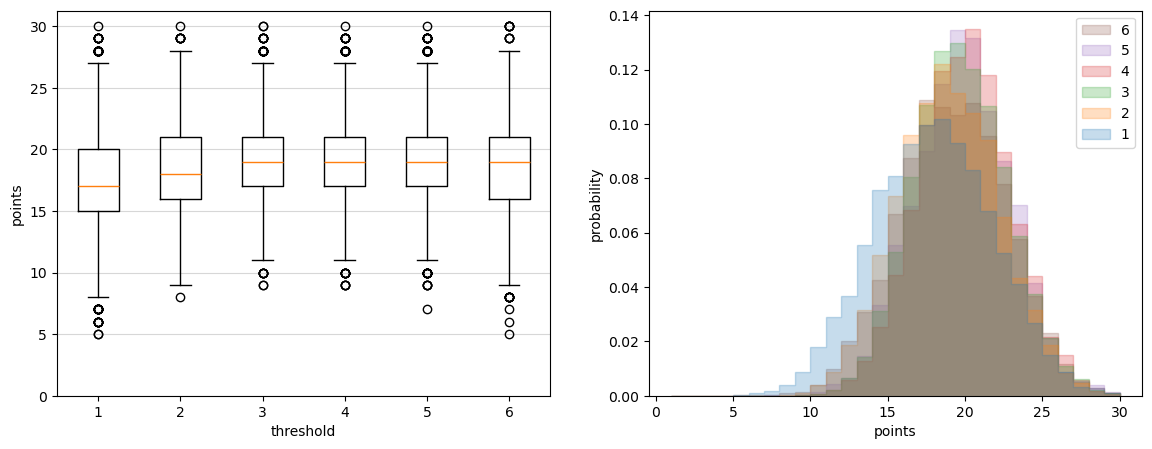

In [4]:
THRESHOLDS = [1, 2, 3, 4, 5, 6]
NUM_SIMS   = 10_000

vals = [(t, *simulate_chance(threshold=t, n=NUM_SIMS)) for t in THRESHOLDS]
sums = [val[1] for val in vals]

fig, axs = plt.subplots(1, 2, figsize=(14,5))

axs[0].boxplot(sums)
axs[0].grid(alpha=0.5, axis="y")
axs[0].set_yticks(np.arange(0, 31, 5))
axs[0].set_xlabel("threshold")
axs[0].set_ylabel("points")

axs[1].hist(sums, density=True, label=[1, 2, 3, 4, 5, 6], histtype='step', fill=True, bins=range(1,31), alpha=0.25)
axs[1].set_xlabel("points")
axs[1].set_ylabel("probability")
axs[1].legend()

plt.show()

## Calculating the Probabilities

In [5]:
def nCk(n, k):
    return math.factorial(n) / (math.factorial(n-k) * math.factorial(k))

def comb_rep(n, r):
    return nCk(n + r - 1, r)

In [6]:
comb_rep(6, 5)

252.0

## Functions that check for the different combinations

All the functions return the value that the combination is worth.

**Idea**: For playing the game it is not only important to know if you have a certain combination, but how close you are. Maybe we should return a number between 0 and 1 that indicates how close we are, with 1 meaning that we have the combination. For example, a result of $\operatorname{grande}(x) = \frac35 = 0.6$ for a play $x$ could indicate, that $x$ has three of the same number (eg. `[1, 1, 1, 2, 3]`).

In [7]:
BONUS_COND = 63
BONUS      = 35

EINPAAR  = 10
ZWEIPAAR = 20
DRILLING = 30
FULL     = 35
STRASSE  = 35
POKER    = 40
GRANDE   = 50

### Upper part

In [8]:
def get_counts(plays):
    # this creates a histogram so to say, telling us how many 1s, 2s, 3s, 4s, 5s, and 6s there where in the play (a play is one throw of a set of dice)
    return np.apply_along_axis(lambda x: np.histogram(x, bins=range(1,8))[0], 1, plays)

In [9]:
yo = roll()
get_counts(yo), yo[0]

(array([[1, 1, 1, 1, 0, 1]]), array([1, 2, 3, 4, 6]))

In [10]:
def upper(play):
    # how useful is this function really? we don't need these values, unless at the end when we wanna see how many points we have in the upper part
    # while playing it is more important to know how many of each number you have rather than the multiplied values
    # we need a different weighting for the upper part
    return get_counts(play) * np.arange(1,7)

In [11]:
upper(yo)

array([[1, 2, 3, 4, 0, 6]])

### Lower Part (i.e., combinations)

The assumption here is that we always throw 5 dice.

#### Implementations

In [12]:
def einpaar(counts):
    return EINPAAR if (counts >= 2).sum() >= 1 else 0

def zweipaar(counts):
    return ZWEIPAAR if (counts >= 2).sum() >= 2 or (counts >= 4).any() else 0

def drilling(counts):
    return DRILLING if (counts >= 3).sum() >= 1 else 0

def full(counts):
    return FULL if ((counts == 2).any() and (counts == 3).any()) or (counts >= 5).any() else 0

def poker(counts):
    return POKER if (counts >= 4).any() else 0

def grande(counts):
    return GRANDE if (counts >= 5).any() else 0

def strasse(counts):
    return STRASSE if (counts <= 1).all() and not (counts[0] and counts[5]) else 0

funcs = [einpaar, zweipaar, drilling, full, strasse, poker, grande]

In [13]:
def check_combinations(counts):
    return np.array([np.apply_along_axis(func, 1, counts) for func in funcs])

#### Simulations

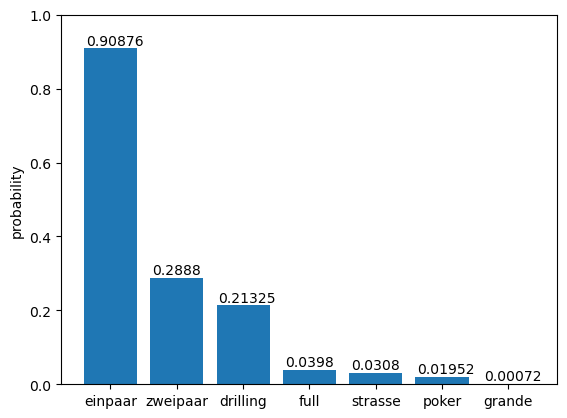

In [14]:
n_sims = 100_000

rolls  = roll(n=n_sims)
counts = get_counts(rolls)

freqs = {func: 0 for func in funcs}
for count in counts:
    for func in funcs:
        freqs[func] += bool(func(count))

plt.bar([func.__name__ for func in freqs.keys()], [val/n_sims for val in freqs.values()])
plt.ylim(0, 1)
plt.ylabel("probability")

xlocs = [i for i in range(0,7)]
for i, v in enumerate([val/n_sims for val in freqs.values()]):
    plt.text(xlocs[i] - 0.37, v + 0.01, str(v))

plt.show()

In [15]:
rolls   = roll(n=50)
counts  = get_counts(rolls)

for play, count in zip(rolls, counts):
    print("-"*105)
    print(f"{play}  " + ", ".join([f"{func.__name__}: {func(count):3.0f}" for func in funcs]))

---------------------------------------------------------------------------------------------------------
[1 2 5 5 6]  einpaar:  10, zweipaar:   0, drilling:   0, full:   0, strasse:   0, poker:   0, grande:   0
---------------------------------------------------------------------------------------------------------
[1 1 2 2 6]  einpaar:  10, zweipaar:  20, drilling:   0, full:   0, strasse:   0, poker:   0, grande:   0
---------------------------------------------------------------------------------------------------------
[1 2 3 4 4]  einpaar:  10, zweipaar:   0, drilling:   0, full:   0, strasse:   0, poker:   0, grande:   0
---------------------------------------------------------------------------------------------------------
[1 1 2 3 4]  einpaar:  10, zweipaar:   0, drilling:   0, full:   0, strasse:   0, poker:   0, grande:   0
---------------------------------------------------------------------------------------------------------
[1 3 6 6 6]  einpaar:  10, zweipaar:   0, dril